In [1]:
########## SECTION 1 - Importing Required Packages and Functions ###############################
import pandas as pd
import numpy as np 
import time
from simulate import generateData
from linear_programs import checkMleExistence

In [17]:
########## SECTION 2 - Generating Simulated Dataset ############################################

# number of observations
n=200

# number of (Gaussian) covariates
p=40

# signal strength
signal_strength = 5

# Parameters for Distribution to draw Betas from. Betas ~ N(mu, stdev^2)
mu = 0
stdev = 1.0

# Generate the data
# - X is an (n,p+1) dimensional array with the n rows corresponding to observations and the p+1 columns
#   corresponding to the covariates + a column of 1's (for the intercept term)
# - Beta is the (p+1,) dimensional array of 'True' regression coefficients
# - y is the (n,) dimensional array of response values for the observations
# - means is the (n,) dimensional array of predicted values (probabilities in case of logistic)
# *THOUGHT: Perhaps we could use another term instead of means to avoid confusion with the systematic component?
# * perhaps y_hat, preds, etc?
X, Beta, y, means = generateData(dist = 'bernoulli', n = n, p = p, mu = mu, stdev = stdev, signal_strength = signal_strength) 

In [18]:
# Sanity Check 1: Should be equal to signal strength
Beta.dot(Beta)/n

5.000000000000001

In [19]:
# Sanity check 2 - Ignore
#from simulate import generateRandomBeta
#beta = generateRandomBeta(q=p, mu=mu, stdev=stdev)
#bb = beta * np.sqrt( (n * signal_strength) / beta.T.dot(beta).values[0,0] )
#bb.values.T.dot(bb.values)/n # check

In [20]:
# Combining the predictor and response data into a single pandas dataframe df
df = pd.DataFrame(X)
y = np.array(y)
y = np.where(y>0,1,-1)# Changed label 0 to -1, For convenience, we choose the label as {-1,1} instead of {0,1}
df['y'] = pd.Series(y)

(array([6., 7., 2., 3., 1., 2., 3., 5., 2., 5., 1., 0., 1., 1., 4., 0., 5.,
        3., 3., 3., 2., 1., 0., 1., 2., 1., 1., 1., 2., 3., 3., 1., 1., 1.,
        0., 4., 0., 2., 4., 1., 4., 1., 2., 0., 1., 0., 0., 4., 4., 0., 1.,
        2., 1., 3., 1., 5., 1., 3., 1., 2., 1., 1., 0., 0., 3., 1., 3., 2.,
        1., 2., 1., 0., 0., 3., 2., 2., 3., 2., 3., 4., 1., 0., 0., 1., 2.,
        0., 0., 4., 3., 1., 1., 2., 3., 2., 4., 4., 4., 4., 2.]),
 array([7.38390334e-04, 1.07135117e-02, 2.06886331e-02, 3.06637545e-02,
        4.06388760e-02, 5.06139974e-02, 6.05891188e-02, 7.05642402e-02,
        8.05393616e-02, 9.05144830e-02, 1.00489604e-01, 1.10464726e-01,
        1.20439847e-01, 1.30414969e-01, 1.40390090e-01, 1.50365211e-01,
        1.60340333e-01, 1.70315454e-01, 1.80290576e-01, 1.90265697e-01,
        2.00240818e-01, 2.10215940e-01, 2.20191061e-01, 2.30166183e-01,
        2.40141304e-01, 2.50116425e-01, 2.60091547e-01, 2.70066668e-01,
        2.80041790e-01, 2.90016911e-01, 2.99992032

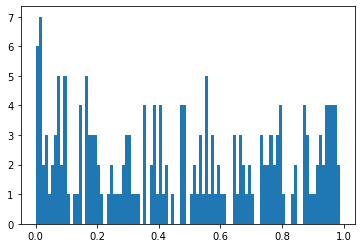

In [21]:
# QUICK ASIDE...
# Looking at distribution of means
import matplotlib.pyplot as plt
min_mean = min(means)
max_mean = max(means)
plt.hist(means, bins=np.arange(min_mean, max_mean, (max_mean-min_mean)/100))

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  1.,  0.,
         0.,  3.,  1.,  0.,  0.,  2.,  1.,  3.,  4.,  3.,  4.,  2.,  0.,
         4.,  2.,  8.,  6.,  3.,  2.,  4.,  6.,  4.,  5.,  7.,  7.,  1.,
         8.,  3., 10.,  6.,  3.,  3.,  7.,  3.,  5.,  5.,  6.,  4.,  0.,
         3.,  0.,  4.,  4.,  1.,  2.,  3.,  2.,  1.,  4.,  1.,  2.,  2.,
         3.,  1.,  0.,  3.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]),
 array([-7.2102993 , -7.07472939, -6.93915948, -6.80358957, -6.66801965,
        -6.53244974, -6.39687983, -6.26130992, -6.12574001, -5.9901701 ,
        -5.85460018, -5.71903027, -5.58346036, -5.44789045, -5.31232054,
        -5.17675062, -5.04118071, -4.9056108 , -4.77004089, -4.63447098,
        -4.49890107, -4.36333115, -4.22776124, -4.09219133, -3.95662142,
        -3.82105151, -3.68548159, -3.54991168, -3.41434177, -3.27877186,
 

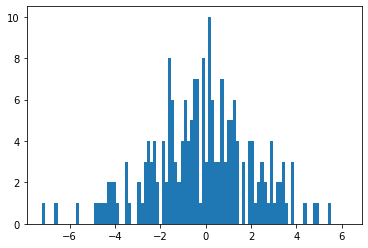

In [22]:
# Looking at distribution of systematic components (would prefer to call these the "means")
sys = X.dot(Beta)
min_sys = min(sys)
max_sys = max(sys)
plt.hist(sys, bins=np.arange(min_sys, max_sys, (max_sys-min_sys)/100))

In [23]:
# Checking percentiles of 'sys'. For signal strength of 5, 2.5th percentile should be > ~-4.472
# and 97.5th percentile should be < ~4.472
print(' 2.5th percentile: '+str(np.percentile(sys,2.5)))
print('97.5th percentile: '+str(np.percentile(sys,97.5)))

 2.5th percentile: -4.580159296247452
97.5th percentile: 3.9119650785253834


In [28]:
########## SECTION 3 -  ############################################
########## SECTION 2 - Generating Simulated Dataset ############################################

# Given a data sample (y_i, X_i), start by choosing a "fine grid" of kappas <= 1/2
kappaArray = np.arange(0.2,0.61,0.01) # CHANGED TO SMALLEST VALUE TO 0.1

# Initializing list to hold proportions of times MLE *** does not **** exist at each kappa
kappaProportion = []

d1 = time.time()

# For each k_j in the grid, we do the following:
for kappa in kappaArray:
    
    # Set sample size to n_j =p / k_j (rounding off to nearest integer)
    # NOTE: FOR LARGE P THERE MAY NOT BE ENOUGH SAMPLES FOR SMALL KAPPA!
    sampleSize = int(round(p/kappa))

    # Here, we draw several samples and check to see if the MLE exists. B is the number of
    # rounds of sampling
    B = 50
    
    # nMleDNE is the total number of times the MLE *** Does Not Exist *** for each kappa (k_j). This
    # is initially set to 0
    nMleDNE = 0
    for i in range(B):
        subSample = df.sample(n=sampleSize) # draw the sample
        subSample =subSample.reset_index(drop = True) # Reindexing is necessary because df.sample draws 
                                                        # the originial index from the dataframe
        
        mleStatus = checkMleExistence(subSample) # check if MLE exists
        # Note that checkMleExistence returns a coded value. The list of coded values can be
        # found here: https://www.gurobi.com/documentation/9.0/refman/optimization_status_codes.html
        # We are most interested in the number of times (out of B times) MLE does not exist.
        # If MLE does not exist, the checkMleExistence function will return status code 2 indicating that the 
        # LP has an optimal solution. 
        
        if mleStatus == 2:
            nMleDNE +=1
            
    # Dividing nMleExist by B gives an estimate of the proportion of times the MLE exists.
    propMleDNE = nMleDNE/B
    kappaProportion.append(propMleDNE)
    

# Now, we need (kappa_j-1, kappa_j) such that kappa_j is the smallest value for which the proportion of times
# the MLE does not exist
uIdx = 0
for kappaProp in kappaProportion:
    if kappaProp>=0.5:
        uIdx = kappaProportion.index(kappaProp) # index of kappa_j
        break
if uIdx != 0:
    uKappa = kappaArray[uIdx] # kappa_j
    lKappa = kappaArray[uIdx-1] # kappa_j-1
else:
    print('Method Failed, All Subsamples are separable!')

d2 = time.time()
delta = round(d2 - d1)
print('Lower Bound of Kappa:',lKappa,'Upper Bound of Kappa:',uKappa, 'kappa proportions:', kappaProportion)
print('Time for the Code to run:',delta)

Lower Bound of Kappa: 0.35000000000000014 Upper Bound of Kappa: 0.36000000000000015 kappa proportions: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.04, 0.04, 0.1, 0.2, 0.24, 0.28, 0.3, 0.46, 0.48, 0.64, 0.56, 0.68, 0.7, 0.7, 0.66, 0.86, 0.86, 0.88, 0.96, 0.88, 0.98, 0.98, 1.0, 1.0, 1.0, 0.98, 0.98, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Time for the Code to run: 100
